In [ ]:
import gdown
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pprint
import random
import pandas as pd
import pulp
import itertools
import requests
import random
from geopy.distance import geodesic
import time
import pandas as pd
import os

Downloading...
From (original): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf
From (redirected): https://drive.google.com/uc?id=1zq17RENYLU1qrE2gNPsxRAPoysWMZAqf&confirm=t&uuid=f7f77dc0-01a6-45e5-b80c-b576c9e0bb17
To: /content/mpsis_setup.py
100%|██████████| 12.1k/12.1k [00:00<00:00, 14.6MB/s]


Mounted at /content/drive


In [ ]:
def generate_random_point(sw_lat, sw_lng, ne_lat, ne_lng):
    lat = random.uniform(sw_lat, ne_lat)
    lng = random.uniform(sw_lng, ne_lng)
    return lat, lng

def snap_to_road(lat, lng, api_key):
    url = f'https://roads.googleapis.com/v1/nearestRoads?points={lat},{lng}&key={api_key}'
    response = requests.get(url)
    data = response.json()
    if 'snappedPoints' in data and len(data['snappedPoints']) > 0:
        snapped_point = data['snappedPoints'][0]['location']
        return snapped_point['latitude'], snapped_point['longitude']
    return None

def get_road_distance_time(origin, destination, api_key):
    origin_str = f'{origin[0]}, {origin[1]}'
    destination_str = f'{destination[0]}, {destination[1]}'
    departure_time = int(time.time()) + 24 * 3600
    url = (
        f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&origins={origin_str}'
        f'&destinations={destination_str}&mode=driving&departure_time={departure_time}&key={api_key}'
    )
    response = requests.get(url)
    data = response.json()

    if data['status'] == 'OK':
        element = data['rows'][0]['elements'][0]
        if element['status'] == 'OK':
            distance_text = element['distance']['text']
            distance = float(distance_text.replace(' km', '').replace(',', ''))

            duration_text = element['duration']['text']
            duration_parts = duration_text.split()
            duration = int(duration_parts[0])
            if "hour" in duration_text:
                duration = int(duration_parts[0]) * 60 + int(duration_parts[2])

            return distance, duration
        else:
            return None, None
    else:
        return None, None

def find_center(sw_lat, sw_lng, ne_lat, ne_lng):
    center_lat = (sw_lat + ne_lat) / 2
    center_lng = (sw_lng + ne_lng) / 2
    return center_lat, center_lng

def generate_list(n, target_sum):
    if n <= 1:
        raise ValueError("The length of the list must be greater than 1.")
    if target_sum < 0:
        raise ValueError("The target sum must be non-negative.")
    result = [0]
    random_values = np.random.rand(n - 1)
    random_values *= target_sum / np.sum(random_values)
    rounded_values = np.round(random_values, 2)
    difference = target_sum - np.sum(rounded_values)

    if len(rounded_values) > 0:
        rounded_values[-1] += difference

    result.extend(rounded_values)

    return result

def crop_matrix(data, N):
    return [row[:N] for row in data[:N]]

In [ ]:
df = pd.read_csv(os.path.join("", "FILE"))

In [ ]:
real_distance_columns = [col for col in df.columns if col.startswith('Road Distance to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
cost = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Road Distance to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name]

            cost[i][j] = 1000000

print("Cost matrix:")
for row in cost:
    print(f"{row},")

real_distance_columns = [col for col in df.columns if col.startswith('Time to Point')]
df_filtered = df[real_distance_columns]

num_points = len(df_filtered)
T = [[0] * num_points for _ in range(num_points)]

for i in range(num_points):
    for j in range(num_points):
        if i != j:
            column_name = f'Time to Point {j + 1}'
            distance = df_filtered.iloc[i][column_name]

            T[i][j] = int(float(distance))




Cost matrix:
[0, 499, 122, 500, 817, 655, 182, 288, 370, 343, 575, 627, 580, 557, 846, 582, 343, 801, 696, 299, 223, 759, 714, 645, 857, 724, 684, 616, 433, 764, 475, 109, 397, 611, 284, 778, 170, 275, 253, 454, 110, 978, 457, 435, 254, 816, 781, 848, 124, 267, 727],
[499, 0, 443, 211, 1235, 466, 412, 318, 269, 281, 512, 363, 1108, 91, 926, 776, 851, 1235, 570, 211, 380, 1003, 655, 991, 684, 574, 1088, 592, 481, 1294, 1005, 492, 905, 295, 792, 842, 398, 783, 703, 847, 486, 780, 455, 943, 762, 595, 580, 1252, 615, 389, 919],
[122, 443, 0, 441, 837, 525, 74, 182, 311, 210, 445, 425, 698, 498, 724, 443, 461, 821, 566, 240, 67, 779, 584, 665, 727, 594, 704, 487, 304, 784, 495, 57, 515, 474, 402, 653, 49, 393, 273, 474, 128, 848, 327, 553, 372, 686, 651, 868, 245, 322, 747],
[500, 211, 441, 0, 1051, 284, 327, 192, 148, 176, 330, 181, 1019, 268, 734, 594, 850, 1053, 387, 237, 372, 819, 472, 808, 506, 392, 906, 409, 251, 1106, 756, 467, 904, 112, 791, 659, 396, 782, 508, 665, 485, 631, 273, 9

In [ ]:
nof_clients = [10,15,20,25,30,35,40,45,50]
nof_trials = 10

In [ ]:
cost_1 = []
cost_2 = []

nof_clients = list(range(10, 51))
for cybant in nof_clients:
    for buffor in range(10):
        print(f" number_of_clients {cybant}")
        cost_shiffted = crop_matrix(cost, cybant + 1)
        number_of_clients = cybant
        m = 2
        Q = 100

        d = generate_list(number_of_clients + 1, 0.7 * Q * m)
        p = generate_list(number_of_clients + 1, 0.7 * Q * m)

        vrpsdp = 0
        vrpsdp = pulp.LpProblem("VRPSDP", pulp.LpMinimize)

        x = pulp.LpVariable.dicts("x", [(i, j, k) for i in range(number_of_clients+1) for j in range(number_of_clients+1) for k in range(m)], cat='Binary')
        y = pulp.LpVariable.dicts("y", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')
        z = pulp.LpVariable.dicts("z", [(i, j) for i in range(number_of_clients+1) for j in range(number_of_clients+1)], lowBound=0, cat='Continuous')

        vrpsdp += pulp.lpSum(cost_shiffted[i][j] * x[i, j, k] for k in range(m) for i in range(number_of_clients+1) for j in range(number_of_clients+1) if i != j)

        for j in range(1, number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i, j, k] for k in range(m) for i in range(number_of_clients+1) if i != j) == 1

        for k in range(m):
          for j in range(number_of_clients+1):
            vrpsdp += pulp.lpSum(x[i,j,k] for i in range(number_of_clients+1)) - pulp.lpSum(x[j,i,k] for i in range(number_of_clients+1)) == 0

        for k in range(m):
          vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1)) == 1

        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(y[j,i] for i in range(number_of_clients+1)) - pulp.lpSum(y[i,j] for i in range(number_of_clients+1)) == p[j]

        for j in range(1, number_of_clients+1):
          vrpsdp += pulp.lpSum(z[i,j] for i in range(number_of_clients+1)) - pulp.lpSum(z[j,i] for i in range(number_of_clients+1)) == d[j]

        for i in range(number_of_clients+1):
          for j in range(number_of_clients+1):
            if i != j:
              vrpsdp += y[i,j] + z[i,j] <= Q * pulp.lpSum(x[i,j,k] for k in range(m))

        vrpsdp += pulp.lpSum(x[0,j,k] for j in range(1, number_of_clients+1) for k in range(m)) == m
        for i in range(1,number_of_clients+1):
          vrpsdp += pulp.lpSum(x[i,j,k] for j in range(number_of_clients+1) for k in range(m) if i != j) == 1

        vrpsdp.solve()
        print(pulp.value(vrpsdp.objective))
        cost_1.append(pulp.value(vrpsdp.objective))

        number_of_clients = cybant
        number_of_vehicles = 2  # liczba pojazdów
        capacity_of_vehicle = 100  # pojemność pojazdu
        cost_shiffted = crop_matrix(cost, cybant + 1)  # macierz kosztów
        demand_of_client = d  # zapotrzebowanie klientów

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        print(pulp.value(problem.objective))

        cost_2.append(pulp.value(problem.objective))


In [ ]:
nof_clients = list(range(10, 51))
cost_2 =  [[] for _ in range(len(nof_clients))]
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in range(1):
        print(f" number_of_trial {buffor}")

        number_of_clients = cybant
        number_of_vehicles = 2
        capacity_of_vehicle = 100
        cost_shiffted = crop_matrix(cost, cybant + 1)
        demand_of_client = generate_list(number_of_clients + 1, 0.3 * capacity_of_vehicle * number_of_vehicles)

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        cost_2[which_list_to_add].append(pulp.value(problem.objective))

 number_of_clients 10
 number_of_trial 0
 number_of_clients 11
 number_of_trial 0
 number_of_clients 12
 number_of_trial 0
 number_of_clients 13
 number_of_trial 0
 number_of_clients 14
 number_of_trial 0
 number_of_clients 15
 number_of_trial 0
 number_of_clients 16
 number_of_trial 0
 number_of_clients 17
 number_of_trial 0
 number_of_clients 18
 number_of_trial 0
 number_of_clients 19
 number_of_trial 0
 number_of_clients 20
 number_of_trial 0
 number_of_clients 21
 number_of_trial 0
 number_of_clients 22
 number_of_trial 0
 number_of_clients 23
 number_of_trial 0
 number_of_clients 24
 number_of_trial 0
 number_of_clients 25
 number_of_trial 0
 number_of_clients 26
 number_of_trial 0
 number_of_clients 27
 number_of_trial 0
 number_of_clients 28
 number_of_trial 0
 number_of_clients 29
 number_of_trial 0
 number_of_clients 30
 number_of_trial 0
 number_of_clients 31
 number_of_trial 0
 number_of_clients 32
 number_of_trial 0
 number_of_clients 33
 number_of_trial 0
 number_of_clien

In [ ]:
import math
nof_clients = list(range(10, 51))
cost_3 =  [[] for _ in range(len(nof_clients))]
to_crop = [4] * (len(nof_clients) +10)
print(to_crop)
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in range(1):
        print(f" number_of_trial {buffor}")
        number_of_clients = cybant

        L_B = list(range(1, number_of_clients + 1))
        SOURCE = 0
        to_crop_for_back = to_crop[which_list_to_add]

        midpoint = number_of_clients - to_crop_for_back
        L = L_B[:midpoint]
        L0 = L[:]
        L0.insert(0,0)
        B = L_B[midpoint:]
        B0 = B[:]
        B0.insert(0,0)
        Cu = L_B
        V = list(range(0, number_of_clients + 1))

        Q = 100
        K = 2

        D = generate_list(len(L) + 1, 0.4 * Q * K)

        for buffor in range(cybant):
          D.append(1)

        Kl = K
        Kb = K
        cost_shiffted = crop_matrix(cost,cybant+1)
        s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
        e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
        l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

        model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

        cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
        model += cost_function_model

        model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

        for j in L:
          model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

        for j in L:
          model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

        for j in L:
          model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

        for j in L:
          for i in L0:
            if i != j:
              model += l[(i,j)] <= Q * s[(i,j)]

        fraaction7 = pulp.lpSum(D[j] for j in L)/Q
        model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

        model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

        for j in B:
          model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

        for j in B:
          model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

        for j in B:
          model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

        for j in B0:
          for i in B:
            if i != j:
              model += l[i,j] <= Q * s[i,j]

        fraaction13 = pulp.lpSum(D[j] for j in B)/Q
        model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
        model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

        model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

        for i in V:
          for j in V:
            if i != j:
              model += s[i,j] + s[j,i] <= 1

        model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

        model += pulp.lpSum(s[0, j] for j in B) == 0

        model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

        model.solve()

        if pulp.LpStatus[model.status] == "Optimal":
          cost_3[which_list_to_add].append(pulp.value(model.objective))
        else:
          print(pulp.LpStatus[model.status])

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
 number_of_clients 10
 number_of_trial 0
 number_of_clients 11
 number_of_trial 0
 number_of_clients 12
 number_of_trial 0
 number_of_clients 13
 number_of_trial 0
 number_of_clients 14
 number_of_trial 0
 number_of_clients 15
 number_of_trial 0
 number_of_clients 16
 number_of_trial 0
 number_of_clients 17
 number_of_trial 0
 number_of_clients 18
 number_of_trial 0
 number_of_clients 19
 number_of_trial 0
 number_of_clients 20
 number_of_trial 0
 number_of_clients 21
 number_of_trial 0
 number_of_clients 22
 number_of_trial 0
 number_of_clients 23
 number_of_trial 0
 number_of_clients 24
 number_of_trial 0
 number_of_clients 25
 number_of_trial 0
 number_of_clients 26
 number_of_trial 0
 number_of_clients 27
 number_of_trial 0
 number_of_clients 28
 number_of_trial 0
 number_of_clients 29
 number_of_trial 0
 number_of_clients 30
 num

In [ ]:
print(cost_3)

[[3827.0], [4001.0], [4045.0], [4418.0], [5309.0], [5045.0], [5129.0], [5010.0], [5501.0], [5608.0], [5620.0], [5492.999999999939], [5597.999999999998], [5533.0], [6009.0], [6025.999999999987], [6110.999999999989], [6231.0], [6229.0], [6635.0], [6502.0], [6358.0], [6463.0], [6790.0], [6400.999999999998], [7044.000000000006], [7044.0], [6749.9999999999945], [6785.0], [6454.999999999775], [6432.000000000016], [7028.999999999972], [7301.999999999993], [7126.999999999932], [7389.999999999968], [7353.0], [7375.0], [8022.999999999993], [8277.999999999924], [8568.999999999865], [7976.000000000147]]


In [ ]:
cost_2 = [[3219.0], [3270.0], [3559.0], [3707.0], [3892.0], [4060.0], [4097.0], [4108.0], [4202.0], [4274.0], [4383.0], [4468.0], [4534.0], [4558.0], [4976.0], [4968.0], [5005.0], [5042.0], [5241.0], [5315.0], [5559.0], [5511.0], [5679.0], [5701.0], [5731.000000000069], [5738.0], [5740.999999999937], [5790.999999999924], [6003.0], [6000.0], [6045.99999999995], [6209.999999999864], [6204.0], [6226.0], [6288.999999999393],[6204.0],[6390.999999999393],[6304.0],[6395.999999999393],[6043.0],[6643]]
cost_3 = [[3827.0], [4001.0], [4045.0], [4418.0], [5309.0], [5045.0], [5129.0], [5010.0], [5501.0], [5608.0], [5620.0], [5492.999999999939], [5597.999999999998], [5533.0], [6009.0], [6025.999999999987], [6110.999999999989], [6231.0], [6229.0], [6635.0], [6502.0], [6358.0], [6463.0], [6790.0], [6400.999999999998], [7044.000000000006], [7044.0], [6749.9999999999945], [6785.0], [6454.999999999775], [6432.000000000016], [7028.999999999972], [7301.999999999993], [7126.999999999932], [7389.999999999968], [7353.0], [7375.0], [8022.999999999993], [8277.999999999924], [8568.999999999865], [7976.000000000147]]


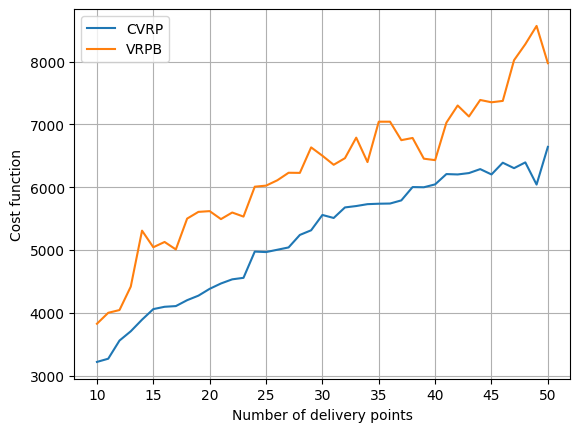

In [ ]:
output_cvrp_2 = []
for x in cost_2:
  output_cvrp_2.append(x[-1])

output_vrpb_2 = []
for x in cost_3:
  output_vrpb_2.append(x[0])

plt.plot(nof_clients, output_cvrp_2, label='CVRP')
plt.plot(nof_clients, output_vrpb_2, label='VRPB')


plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
nof_clients = list(range(10, 30))
cost_1 =  [0] * len(nof_clients)
cost_3 =  [0] * len(nof_clients)
cost_4 =  [0] * len(nof_clients)
cost_5 =  [0] * len(nof_clients)
number_of_vechicles_list = [1,3,4,5]
for cybant in nof_clients:
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in number_of_vechicles_list:
        print(f" nofvech {buffor}")

        number_of_clients = cybant
        number_of_vehicles = buffor
        capacity_of_vehicle = 100
        cost_shiffted = crop_matrix(cost, cybant + 1)
        demand_of_client = generate_list(number_of_clients + 1, 0.3 * capacity_of_vehicle * number_of_vehicles)

        problem = pulp.LpProblem("CVRP", pulp.LpMinimize)

        x = [[[pulp.LpVariable(f"x{i}_{j},{k}", cat="Binary") if i != j else None
                  for k in range(number_of_vehicles)]
                  for j in range(number_of_clients + 1)]
                for i in range(number_of_clients + 1)]

        problem += pulp.lpSum(cost_shiffted[i][j] * x[i][j][k] if i != j else 0
                              for k in range(number_of_vehicles)
                              for j in range(number_of_clients + 1)
                              for i in range(number_of_clients + 1))

        for j in range(1, number_of_clients + 1):
            problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for k in range(number_of_vehicles)) == 1

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(x[0][j][k] for j in range(1, number_of_clients + 1)) == 1
            problem += pulp.lpSum(x[i][0][k] for i in range(1, number_of_clients + 1)) == 1

        for k in range(number_of_vehicles):
            for j in range(number_of_clients + 1):
                problem += pulp.lpSum(x[i][j][k] if i != j else 0
                                      for i in range(number_of_clients + 1)) - \
                          pulp.lpSum(x[j][i][k] for i in range(number_of_clients + 1)) == 0

        for k in range(number_of_vehicles):
            problem += pulp.lpSum(demand_of_client[j] * x[i][j][k] if i != j else 0
                                  for i in range(number_of_clients + 1)
                                  for j in range(1, number_of_clients + 1)) <= capacity_of_vehicle

        u = pulp.LpVariable.dicts("u", range(1, number_of_clients + 1), 0, number_of_clients, cat="Continuous")
        for i in range(1, number_of_clients + 1):
            for j in range(1, number_of_clients + 1):
                if i != j:
                    for k in range(number_of_vehicles):
                        problem += u[i] - u[j] + (number_of_clients * x[i][j][k]) <= number_of_clients - 1

        problem.solve()

        if number_of_vehicles == 1:
          cost_1[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 3:
          cost_3[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 4:
          cost_4[which_list_to_add] = (pulp.value(problem.objective))
        elif number_of_vehicles == 5:
          cost_5[which_list_to_add] = (pulp.value(problem.objective))

%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 10
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 11
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 12
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 13
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 14
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 15
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 16
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 17
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 18
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 19
 nofvech 1
 nofvech 3
 nofvech 4
 nofvech 5
%%%%%%%%%%%%%%%%%%%%%%%%%% number_of_clients 20
 nofvech 1
 nofvech 3
 nofvech 4

In [ ]:
print(cost_1)
print(cost_3)
print(cost_4)
print(cost_5)
# [2989.0, 3040.0, 3329.0, 3477.0, 3662.0, 3830.0, 3867.0, 3878.0, 3972.0, 4044.0, 4117.0, 4202.0, 4268.0, 4292.0, 4710.0, 4702.0, 4739.0, 4776.0, 4975.0, 5049.0]
# [3576.0, 3627.0, 3916.0, 4064.0, 4249.0, 4417.0, 4454.0, 4465.0, 4559.0, 4631.0, 4708.0, 4793.0, 4859.0, 4883.0, 5301.0, 5293.0, 5330.0, 5367.0, 5566.0, 5640.0]
# [4136.0, 4187.0, 4476.0, 4624.0, 4826.0, 4994.0, 5031.0, 5042.0, 5136.0, 5147.0, 5169.0, 5162.0, 5320.0, 5344.0, 5762.0, 5754.0, 5917.0, 5828.0, 6027.0, 6101.0]
# [4713.0, 4764.0, 5053.0, 5201.0, 5426.0, 5594.0, 5680.0, 5830.999999999997, 5785.0, 5867.0, 5663.999999999944, 5749.0, 5815.0, 5941.0, 6186.0, 6337.0, 6374.0, 6323.0, 6470.999999998906, 6680.000000000038]

[2989.0, 3040.0, 3329.0, 3477.0, 3662.0, 3830.0, 3867.0, 3878.0, 3972.0, 4044.0, 4117.0, 4202.0, 4268.0, 4292.0, 4710.0, 4702.0, 4739.0, 4776.0, 4975.0, 5049.0]
[3576.0, 3627.0, 3916.0, 4064.0, 4249.0, 4417.0, 4454.0, 4465.0, 4559.0, 4631.0, 4708.0, 4793.0, 4859.0, 4883.0, 5301.0, 5293.0, 5330.0, 5367.0, 5566.0, 5640.0]
[4136.0, 4187.0, 4476.0, 4624.0, 4826.0, 4994.0, 5031.0, 5042.0, 5136.0, 5147.0, 5169.0, 5162.0, 5320.0, 5344.0, 5762.0, 5754.0, 5917.0, 5828.0, 6027.0, 6101.0]
[4713.0, 4764.0, 5053.0, 5201.0, 5426.0, 5594.0, 5680.0, 5830.999999999997, 5785.0, 5867.0, 5663.999999999944, 5749.0, 5815.0, 5941.0, 6186.0, 6337.0, 6374.0, 6323.0, 6470.999999998906, 6680.000000000038]


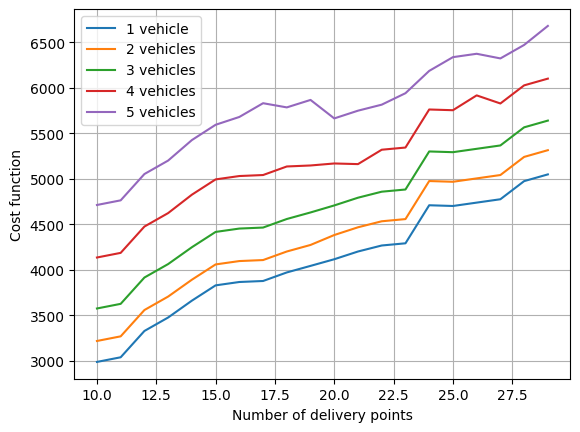

In [ ]:
plt.plot(nof_clients, cost_1, label='1 vehicle')
plt.plot(nof_clients, output_cvrp_2[:20], label='2 vehicles')
plt.plot(nof_clients, cost_3, label='3 vehicles')
plt.plot(nof_clients, cost_4, label='4 vehicles')
plt.plot(nof_clients, cost_5, label='5 vehicles')

plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')

plt.legend()
plt.grid(True)

plt.show()

In [ ]:
import math
nof_clients = list(range(10, 20))
cost_1 =  [0] * len(nof_clients)
cost_2 =  [0] * len(nof_clients)
cost_3 =  [0] * len(nof_clients)
cost_4 =  [0] * len(nof_clients)
cost_5 =  [0] * len(nof_clients)
number_of_vechicles_list = [1,2,3,4,5]
to_crop = [5] * (len(nof_clients) +10)
for cybant in nof_clients:
    print(f" number_of_clients {cybant}")
    which_list_to_add = nof_clients.index(cybant)

    for buffor in number_of_vechicles_list:
        print(f" number of cleints {buffor}")
        number_of_clients = cybant

        L_B = list(range(1, number_of_clients + 1))
        SOURCE = 0
        to_crop_for_back = to_crop[which_list_to_add]

        midpoint = number_of_clients - to_crop_for_back
        L = L_B[:midpoint]
        L0 = L[:]
        L0.insert(0,0)
        B = L_B[midpoint:]
        B0 = B[:]
        B0.insert(0,0)
        Cu = L_B
        V = list(range(0, number_of_clients + 1))

        Q = 100
        K = buffor

        L_demmand = generate_list(len(L) + 1, 0.9 * Q * K)
        B_demand  = generate_list(len(B) + 1, 0.85 * Q * K)

        D = L_demmand + B_demand[1:]

        Kl = K
        Kb = K
        cost_shiffted = crop_matrix(cost,cybant+1)
        s = pulp.LpVariable.dicts('s', [(i, j) for i in V for j in V if i != j], cat = pulp.LpBinary)
        e = pulp.LpVariable.dicts('e', [(i, j) for i in L for j in B0 if i != j], cat = pulp.LpBinary)
        l = pulp.LpVariable.dicts('l', [(i, j) for i in V for j in V if i != j], 0, cat = "Continuous")

        model = pulp.LpProblem("vehicle_routing", pulp.LpMinimize)

        cost_function_model = pulp.lpSum(s[i,j] * cost_shiffted[i][j] for i in V for j in V if i != j) + pulp.lpSum(e[i,j] * cost[i][j] for i in L for j in B0 if i != j)
        model += cost_function_model

        model += pulp.lpSum(s[i,j] for i in L0 for j in L if i != j) == len(L)

        for j in L:
          model += pulp.lpSum(l[i,j] for i in L0 if i != j) - pulp.lpSum(l[j,k] for k in L0 if k != j) == D[j]

        for j in L:
          model += pulp.lpSum(s[i,j] for i in L0 if i != j) == 1

        for j in L:
          model += pulp.lpSum(s[j,k] for k in L if k != j) + pulp.lpSum(e[j,k] for k in B0 if k != j)  ==  pulp.lpSum(s[(i,j)] for i in L0 if i != j)

        for j in L:
          for i in L0:
            if i != j:
              model += l[(i,j)] <= Q * s[(i,j)]

        fraaction7 = pulp.lpSum(D[j] for j in L)/Q
        model += pulp.lpSum(s[0,j] for j in L) >= max(float(fraaction7.value()),Kl)

        model += pulp.lpSum(s[i,j] for i in B for j in B0 if i != j) == len(B)

        for j in B:
          model += pulp.lpSum(l[i,j] for i in B if i != j) - pulp.lpSum(l[(j,k)] for k in B0 if k != j) == -D[j]

        for j in B:
          model += pulp.lpSum(s[j,i] for i in B0 if j != i) == 1

        for j in B:
          model += pulp.lpSum(s[k,j] for k in B if k != j) + pulp.lpSum(e[k,j] for k in L) == pulp.lpSum(s[(j,i)] for i in B0 if j != i)

        for j in B0:
          for i in B:
            if i != j:
              model += l[i,j] <= Q * s[i,j]

        fraaction13 = pulp.lpSum(D[j] for j in B)/Q
        model += max(int(fraaction13.value()),Kb) <= pulp.lpSum(s[i,0] for i in B)
        model += pulp.lpSum(s[(i,0)] for i in B) <= pulp.lpSum(s[0, j] for j in L)

        model += pulp.lpSum(s[i,0] for i in B) + pulp.lpSum(e[i, 0] for i in L) == pulp.lpSum(s[0,j] for j in L)

        for i in V:
          for j in V:
            if i != j:
              model += s[i,j] + s[j,i] <= 1

        model += pulp.lpSum(s[i,j] for i in B for j in L if i != j) == 0

        model += pulp.lpSum(s[0, j] for j in B) == 0

        model += pulp.lpSum(s[i,j] for i in L for j in B0 if i != j) == 0

        model.solve()

        print(pulp.value(model.objective))

        if pulp.LpStatus[model.status] == "Optimal":
            if K == 1:
              cost_1[which_list_to_add] = (pulp.value(model.objective))
            elif K == 2:
              cost_2[which_list_to_add] = (pulp.value(model.objective))
            elif K == 3:
              cost_3[which_list_to_add] = (pulp.value(model.objective))
            elif K == 4:
              cost_4[which_list_to_add] = (pulp.value(model.objective))
            elif K == 5:
              cost_5[which_list_to_add] = (pulp.value(model.objective))
        else:
            if K == 1:
              cost_1[which_list_to_add] = cost_1[-1]
            elif K == 2:
              cost_2[which_list_to_add] = cost_2[-1]
            elif K == 3:
              cost_3[which_list_to_add] = cost_3[-1]
            elif K == 4:
              cost_4[which_list_to_add] = cost_4[-1]
            elif K == 5:
              cost_5[which_list_to_add] = cost_5[-1]

In [ ]:
# print(cost_1)
# print(cost_3)
# print(cost_4)
# print(cost_5)
cost_1 = [3575.999999999999, 3652.0, 4063.0, 4508.0, 5097.0, 5194.0, 5081.999999999996, 5269.999999999999, 5064.0, 5719.0, 5711.0, 5754.0, 5513.000000000436, 5642.000000000009, 5984.0, 5940.0, 6036.999999999988, 6120.0000000000455, 6255.000000000046, 6617.0000000000855, 6548.999999999968, 6331.000000000674, 6411.0, 6886.0, 6859.000000000002, 6992.0, 7111.0, 7093.999999999898, 6784.999999999916, 6902.999999999999, 6571.0, 7174.000000000276, 6962.000000000033, 7684.99999999997, 7354.0, 7411.9999999999545, 7395.999999999828, 8335.0, 8210.999999999885, 8569.999999999778]
cost_2 = [3827.0, 4001.0, 4045.0, 4418.0, 5309.0, 5045.0, 5129.0, 5010.0, 5501.0, 5608.0, 5620.0,
5492.999999999939, 5597.999999999998, 5533.0, 6009.0, 6025.999999999987, 6110.999999999989,
6231.0, 6229.0, 6635.0, 6502.0, 6358.0, 6463.0, 6790.0, 6400.999999999998, 7044.000000000006,
7044.0, 6749.9999999999945, 6785.0, 6454.999999999775, 6432.000000000016, 7028.999999999972,
7301.999999999993, 7126.999999999932, 7389.999999999968, 7353.0, 7375.0, 8022.999999999993,
8277.999999999924, 8568.999999999865]


cost_3 = [4096.0, 4475.0, 4574.0, 4860.0, 5531.0, 5661.0, 5459.0, 5677.0, 5844.0, 6153.0, 6086.000000000002, 6156.0, 5821.0, 5937.0, 6334.0, 7012.999999999998, 6962.0, 7046.999999999997, 7024.0, 7243.999999999999, 7101.0, 6908.0, 6887.000000000269, 7197.0, 7050.0, 7344.0, 7360.000000000007, 7343.0, 6863.0, 6981.0, 6649.0, 7304.0, 7176.0, 7743.000000000007, 7568.0, 7766.999999999825, 7751.0000000001155, 8498.0, 8266.999999999432, 8655.000000000022]
cost_4 = [4974.0, 5124.0, 5223.0, 5446.0, 6489.0, 6499.0, 6397.0, 6516.0, 7114.0, 6860.0, 6447.0, 6597.0, 6397.0, 6422.0, 7325.0, 8017.0, 7950.0, 8025.0, 7849.0, 8036.000000000015, 7892.9999999999245, 7402.999999999999, 7332.0, 7548.999999999997, 7389.999999999971, 7850.0, 7891.0, 7770.0, 7423.000000000003, 7436.0, 6991.0, 7699.000000000009, 7770.000000000196, 7979.0, 7957.0, 8348.0, 8328.0, 8951.0, 8611.99999999997, 8863.999999999965]
cost_5 = [5950.0, 6146.0, 6229.0, 6438.0, 7485.0, 7674.0, 7542.0, 7654.0, 8248.0, 7669.0, 6988.0, 7359.0, 7561.0, 7426.0, 8329.0, 9297.0, 9219.0, 9185.0, 8964.0, 9066.0, 8937.0, 8232.0, 8164.000000000004, 8324.0, 8041.0, 8425.999999999996, 8441.999999999996, 8453.999999999995, 8113.0000000000155, 8245.0, 7590.999999999995, 8363.999999999996, 8388.0, 8639.0, 8595.0, 9555.999999999985, 9454.999999999998, 9901.0, 9562.000000000004, 9730.0]

nof_clients = list(range(10, 50))

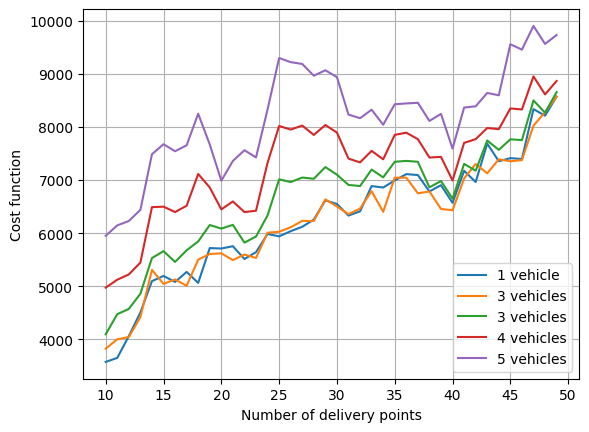

In [ ]:
import matplotlib.pyplot as plt


plt.plot(nof_clients, cost_1, label='1 vehicle')
plt.plot(nof_clients, cost_2, label='3 vehicles')
plt.plot(nof_clients, cost_3, label='3 vehicles')
plt.plot(nof_clients, cost_4, label='4 vehicles')
plt.plot(nof_clients, cost_5, label='5 vehicles')

plt.xlabel('Number of delivery points')
plt.ylabel('Cost function')

plt.legend()
plt.grid(True)

plt.show()